# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline


#read Image
def readIMG(img_name):
    image = mpimg.imread(img_name)
    shape = image.shape
    color_img = np.copy(image)    
    
    return color_img, shape

def plot_n(img, title, cmap=''):
    plt.figure(figsize=(15,12))
    #plt.figure(figsize=(9,7))
    plt.subplots_adjust(wspace=0.14, hspace=0.25)
        
    if len(img) % 2 > 0:
        raw = (len(img)-1) / 2 + 1
        print('raw =' + str(raw))
    else:
        raw = len(img) / 2
        print('raw =' + str(raw))
        
    for i in range(len(img)):

        plt.subplot(raw, 2 , i+1)
        plt.imshow(img[i],cmap=str(cmap))
        plt.title(title[i], fontsize = 15)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def polygon_roi(image, imshape, bottom_left, bottom_right, y_line, x_left, x_right, plot_flag):
    
    img = np.copy(image)


    vertices = np.array([[(bottom_left,imshape[0]),(x_left, y_line), (x_right, y_line), \
                          (bottom_right,imshape[0])]], dtype=np.int32) 
    
    vertices2 = [(bottom_left,imshape[0]),(x_left, y_line),(x_right, y_line), (bottom_right,imshape[0])]
    img_mask = region_of_interest(img, vertices)
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(img_mask)   
    ignore_mask_color = 255
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)           
    masked_edges = cv2.bitwise_and(img, mask)
        
    roi_marked_img = cv2.polylines(img, vertices, True , (255,255,0),3 )

    
    if(plot_flag):
                
        #plot Images
        images = [roi_marked_img, masked_edges]
        titels = ['ROI marked Image','masked_edges']
        plot_n(images,titels,'gray_r')

        # save the ROI Image
        #img = cv2.cvtColor(roi_marked_img,cv2.COLOR_RGB2BGR)
        #write_name = 'output_images/ROI.png'
        #cv2.imwrite(write_name,img)

    return masked_edges,roi_marked_img, vertices, vertices2

def draw_polygon(img, points, color=[200, 200, 200], thickness=2):
    """
    Draws a polygon on th image
    """
    lineType = 8
    shift = 0
    is_closed = True
    cv2.polylines(img, points, is_closed, color, thickness, lineType, shift) 


## Start with Image Processing

All used functions are placed in the Helper Functions above 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from shapely.geometry import Point, Polygon
import os
%matplotlib inline

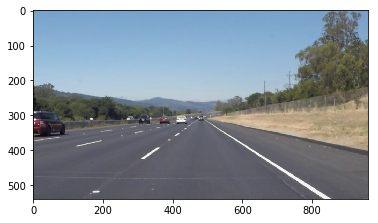

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
img = np.copy(image)
shape = img.shape

plt.imshow(image)
plt.show()

### After reading an image start with Image Processing like:
 - GRAYSCALING 
 - APPLY GAUSSIAN BLUR 
 - APPLY CANNY EDGE DETECTION 
 

raw =2.0


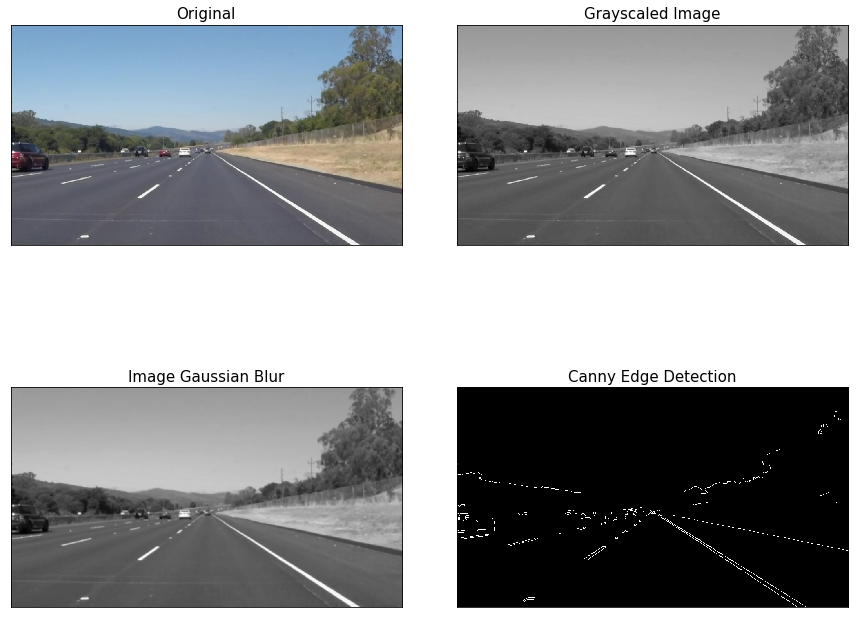

In [5]:
#Grayscale
img_gray = grayscale(img)

#Gaussian blur for the image
kernel_size = 5
img_blur = gaussian_blur(img_gray, kernel_size)

# Canny Edge Detection
low_threshold = 110
high_threshold = 190
img_canny = canny(img_blur, low_threshold, high_threshold)

#plot Images
images = [img, img_gray, img_blur, img_canny]
titels = ['Original','Grayscaled Image','Image Gaussian Blur', 'Canny Edge Detection']
plot_n(images,titels,'gray')

### Next Step - HOUGH SPACE TRANSFORMATION 

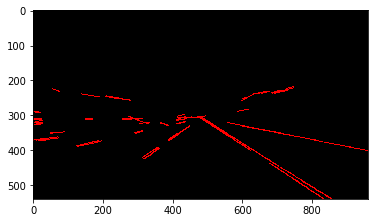

In [6]:
# APPLY HOUGH SPACE TRANSFORMATION

# Define Parameters
min_line_len = 20
max_line_gap = 15

rho = 6
theta = np.pi/100
threshold = 100

img_hough, hough_lines_list = hough_lines(img_canny, rho, theta, threshold, min_line_len, max_line_gap)

#plot Images
plt.imshow(img_hough)
plt.show()

### Define a Region of Interest (ROI)

Define a Region of Interest with five Parameters for a Polygone like in the folloing Image. 

Info: 
- y_line is the parameter for the depth
- vertices -> numpy array with the Parameters for Polygone 
- vertices_points -> List of Parameters of Polygone 


In [14]:
%%html
<img src="Images Notebook/ROI_marked.png", width=400>

raw =3.0


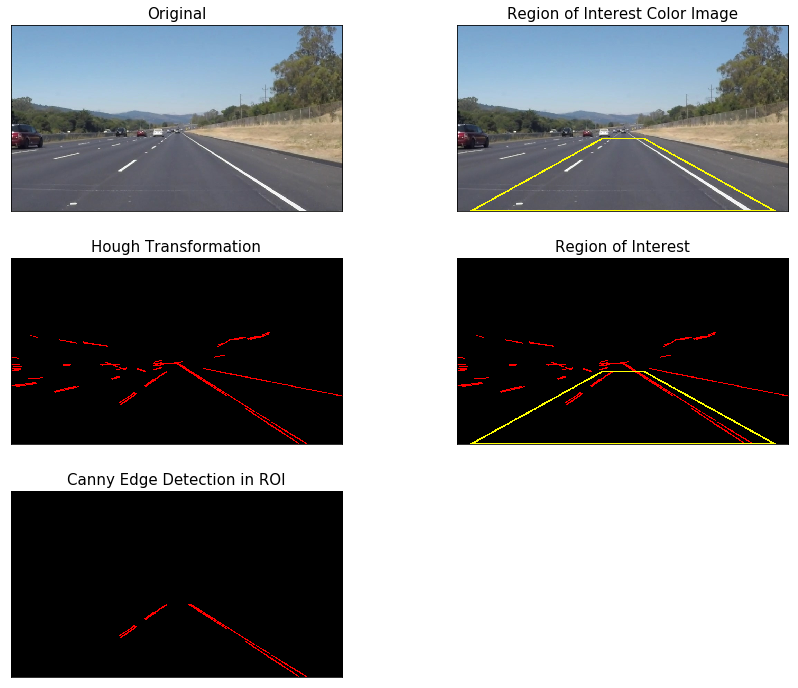

In [24]:
# Define Parameters
y_line  = ysize - 210

x_left  = xsize - 540
x_right = xsize - 420

bottom_left  = 40
bottom_right = xsize - 40

ysize = shape[0]
xsize = shape[1]

masked_edges, roi, vertices, vertices_points = polygon_roi(img_hough, shape, bottom_left, bottom_right,y_line, x_left, x_right, None)

# Save Image
#color_change = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
#cv2.imwrite("test_images_output/ROI.png", color_change)

# load saved Images - was done with the Original Image
ROI_saved = mpimg.imread('test_images_output/ROI.png')

#plot Images
images = [img, ROI_saved, img_hough, roi, masked_edges]
titels = ['Original', 'Region of Interest Color Image','Hough Transformation','Region of Interest', 
          'Canny Edge Detection in ROI']
plot_n(images,titels,'gray')


### Seperate left and right Lane Segments

In [25]:
# APPLY IMAGE MASK TO IMAGE
size_x = shape[1]
size_y = shape[0]
size_h = 210
size_base_w = 880
size_top_w = 120

# SEPERATE LEFT AND RIGHT LANE SEGMENTS
# MASK HOUGH LINES, CALCULATE
lower_gradient_limit = 0.4
upper_gradient_limit = 3
middle_offset = 0

left_lane_lines = np.array([[[0, 0, 0, 0]]])
right_lane_lines = np.array([[[0, 0, 0, 0]]])

mask_polygon = Polygon(vertices_points)

for line in hough_lines_list:
    # Check if at least one endpoint of line is within the mask
    p1 = Point(line[0][0], line[0][1])
    p2 = Point(line[0][2], line[0][3])
    if ((p1.within(mask_polygon)) or (p2.within(mask_polygon))):
        # Check for gradient of the line. negative --> left, positive --> right
        if (p1.x != p2.x):
            gradient = (p1.y - p2.y) / (p1.x - p2.x)
        else:
            gradient = 999
        if ((gradient >= lower_gradient_limit) and (gradient <= upper_gradient_limit)):                
            if ((p1.x > img.shape[1] / 2 - middle_offset) and (p2.x > img.shape[1] / 2 - middle_offset)):
                right_lane_lines = np.append(right_lane_lines, [[[p1.x, p1.y, p2.x, p2.y]]], axis=0)
        if ((gradient >= -upper_gradient_limit) and (gradient <= -lower_gradient_limit)):
            if ((p1.x < img.shape[1] / 2 + middle_offset) and (p2.x < img.shape[1] / 2 + middle_offset)):
                left_lane_lines = np.append(left_lane_lines, [[[p1.x, p1.y, p2.x, p2.y]]], axis=0)
left_lane_lines = np.delete(left_lane_lines, 0, 0)
right_lane_lines = np.delete(right_lane_lines, 0, 0)

# Reshape the point lists from left and right lane markings
left_lane_x_coords = []
left_lane_y_coords = []
right_lane_x_coords = []
right_lane_y_coords = []
for v in left_lane_lines:
    left_lane_x_coords.append(v[0][0])
    left_lane_x_coords.append(v[0][2])
    left_lane_y_coords.append(v[0][1])
    left_lane_y_coords.append(v[0][3])
for v in right_lane_lines:
    right_lane_x_coords.append(v[0][0])
    right_lane_x_coords.append(v[0][2])
    right_lane_y_coords.append(v[0][1])
    right_lane_y_coords.append(v[0][3])

    # Prevent errors if no lane could be found and vector of points is empty
if (len(left_lane_x_coords) == 0):
    left_lane_y_coords = [0, 1]
    left_lane_x_coords = [-99, -99]
if (len(right_lane_x_coords) == 0):
    right_lane_y_coords = [0, 1]
    right_lane_x_coords = [-99, -99]



### Next Step

- Perform Polynome 1.Order to the Lanes
- Add the Lane Lines to the Image and Visualize it

raw =1.0


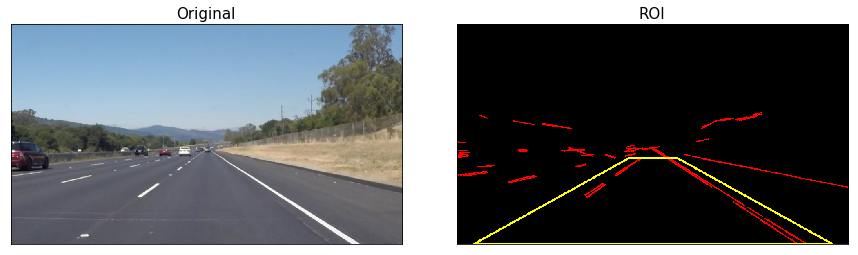

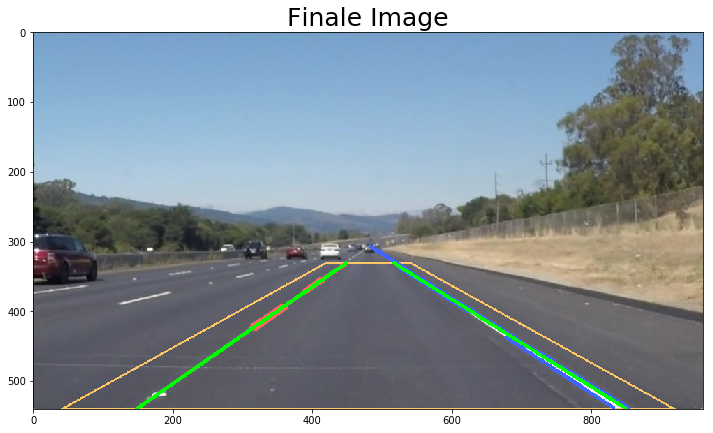

In [30]:
# PERFORM POLYFIT ON LEFT AND RIGHT LANE MARKING 
left_lane_coeefs = np.polyfit(left_lane_x_coords, left_lane_y_coords, deg = 1)
right_lane_coeefs = np.polyfit(right_lane_x_coords, right_lane_y_coords, deg = 1)

# Add the two final Lane Lines to the Image
y_start = size_y
y_end = y_start - size_h
lane_lines = np.array([[[(y_start - left_lane_coeefs[1]) / left_lane_coeefs[0], y_start, (y_end - left_lane_coeefs[1]) / left_lane_coeefs[0], y_end]],
                       [[(y_start - right_lane_coeefs[1]) / right_lane_coeefs[0], y_start, (y_end - right_lane_coeefs[1]) / right_lane_coeefs[0], y_end]]])
right_lane_lines = right_lane_lines.astype(int)  
left_lane_lines = left_lane_lines.astype(int) 
lane_lines = lane_lines.astype(int) 
img_result = np.copy(img)

draw_polygon(img_result, vertices, color=[255, 200, 100], thickness=2)
draw_lines(img_result, right_lane_lines, color=[65, 100, 255], thickness=4)
draw_lines(img_result, left_lane_lines, color=[255, 100, 100], thickness=4)
draw_lines(img_result, lane_lines, color=[0, 255, 0], thickness=4)   

#plot Images
images = [img,roi]
titels = ['Original', 'ROI']

plot_n(images,titels,'gray')
plt.figure(figsize=(12,20))
plt.title("Finale Image", fontsize = 25)
plt.imshow(img_result)
plt.show()